In [1]:
import numpy as np
import warnings 
from sklearn.model_selection import train_test_split
import scipy as scio
from scipy.spatial.distance import pdist
from scipy.linalg import cho_factor, cho_solve, cholesky
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_array, check_random_state
from sklearn.linear_model.ridge import _solve_cholesky_kernel as kernel_solve
from time import time

%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

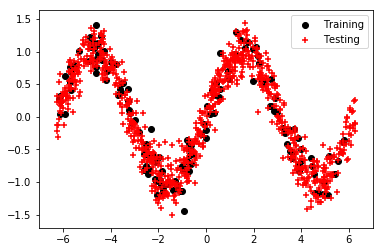

In [2]:
# generate datasets
random_state = 123
num_points = 10000

x_data = np.linspace(-2*np.pi, 2*np.pi, num=num_points)
y_data = np.sin(x_data)

# add some noise
generator = check_random_state(random_state)
y_data += 0.2 * generator.randn(num_points)

# convert to 2D, float array for scikit-learn input
x_data = x_data[:, np.newaxis].astype(np.float)
y_data = y_data[:, np.newaxis].astype(np.float)


# split data into training and testing
train_percent = 0.15

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=train_percent,
    random_state=random_state
)

# plot the training data
fig, ax = plt.subplots()

ax.scatter(x_train[::10], y_train[::10], color='k', label='Training')
ax.scatter(x_test[::10], y_test[::10], color='r', marker='+', label='Testing')

ax.legend()
plt.show()

# remove the mean from the training data
y_mean = np.mean(y_train)

y_train -= y_mean
y_test -= y_mean

In [3]:
# parameter heuristics
mean_sigma = np.mean(pdist(x_train, metric='euclidean'))
lam = 1.0

mean_gamma = 1 / (2 * mean_sigma ** 2)

# construct kernel matrices
K_train = rbf_kernel(X=x_train, gamma=mean_gamma)

### Different Solvers

In [4]:
weights = {}
times = {}

In [5]:
# slow method: solve problem
t0 = time()
weights['solver'] = \
    scio.linalg.solve(K_train + lam * np.eye(x_train.shape[0]), 
                      y_train)
t1 = time() - t0
print('Time taken for solve: {:.4f} secs'.format(t1))

Time taken for solve: 0.1242 secs


In [6]:
# scikit kernel cholesky solver
t0 = time()
weights['scikit_solver'] = kernel_solve(K_train, y_train, lam)
t1 = time() - t0
print('Time taken for scikit-solver: {:.4f} secs'.format(t1))

Time taken for scikit-solver: 0.0854 secs


In [7]:
# cholesky: decomposition: manually
t0 = time()
R = cholesky(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_solver'] = scio.linalg.solve(R, scio.linalg.solve(R.T, y_train))
t1 = time() - t0
print('Time taken for cholesky manually: {:.4f} secs'.format(t1))

Time taken for cholesky manually: 0.2276 secs


In [8]:
# cholesky decomposition: with functions
t0 = time()
R, lower = cho_factor(K_train + lam * np.eye(x_train.shape[0]))
weights['chol_factor'] = cho_solve((R, lower), y_train)
t1 = time() - t0
print('\nTime taken for cholesky with functions: {:.4f} secs\n'.format(t1))


Time taken for cholesky with functions: 0.0579 secs



#### Are they the same?

In [9]:
print('Scikit Solver: {}'.format(
    np.allclose(weights['scikit_solver'],
                weights['solver'])))

print('Cholesky Solver: {}'.format(
    np.allclose(weights['chol_solver'],
                weights['solver'])))

print('Cholesky Factor: {}'.format(
    np.allclose(weights['chol_factor'],
                weights['solver'])))

Scikit Solver: True
Cholesky Solver: True
Cholesky Factor: True


#### Are they faster?

In [10]:
def chol_solver(x, y, K, lam):
    
    R = cholesky(K + lam * np.eye(x.shape[0]))
    
    return scio.linalg.solve(R, scio.linalg.solve(R.T, y))

def chol_factor(x, y, K, lam):
    
    R, lower = cho_factor(K + lam * np.eye(x.shape[0]))
    
    return cho_solve((R, lower), y)

In [11]:
# solver_time = %timeit -o scio.linalg.solve(K_train + lam * np.eye(x_train.shape[0]), y_train)
# scikit_time = %timeit -o kernel_solve(K_train, y_train, lam)
# chol_solver_time = %timeit -o chol_solver(x_train, y_train, K_train, lam)
# chol_factor_time = %timeit -o chol_solver(x_train, y_train, K_train, lam)

### Predictions (Normal)


In [12]:
%%timeit

# calculate the kernel test matrix
K_test = rbf_kernel(X=x_test, gamma=mean_gamma)

# calculate the inverse matrix
K_train_inv = np.linalg.inv(K_train)

# calculate the train-test Kernel matrix
K_traintest = rbf_kernel(x_train, x_test, gamma=mean_gamma)

# calculate the predictions
y_pred = K_traintest.T @ weights['solver']

# calculate the variance
y_var = np.diag(K_test) - np.diag(K_traintest.T @ K_train_inv @ K_traintest)

4.85 s ± 312 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Predictions (Batch)

In [15]:
# split testing data (K-fold)
n_samples, n_dimensions = x_test.shape
n_samples_per_batch = 100
n_batches = int(np.round(n_samples / n_samples_per_batch))

print("Number of Test samples: ", n_samples)
print("Number of samples per batch: ", n_samples_per_batch)
print("Number of batches: {}".format(n_batches))

Number of Test samples:  8500
Number of samples per batch:  100
Number of batches: 85


In [16]:
%%timeit

# Create Batch Iterator Object
BatchIterator = KFold(n_splits=n_batches)

# predefine matrices
y_pred = np.empty(y_test.shape)
variance = np.empty(y_test.shape) 

# calculate the inverse matrix
K_train_inv = np.linalg.inv(K_train)

for (ibatch, (_, ibatch_index)) in enumerate(BatchIterator.split(x_test)):
    
    # calculate the train-test kernel
    K_traintest = rbf_kernel(x_train, x_test[ibatch_index], 
                             gamma=mean_gamma)
    
    # calculate the predictions
    y_pred[ibatch_index] = K_traintest.T @ weights['solver']
    
    # calculate the variance
    K_batch = rbf_kernel(x_test[ibatch_index], gamma=mean_gamma)
    
    variance[ibatch_index, 0] = np.diag(K_batch) - \
        np.diag(K_traintest.T @ K_train_inv @ K_traintest)

1.01 s ± 93.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
BatchIterator = KFold(n_splits=n_batches)

# predefine matrices
y_pred = np.empty(y_test.shape)
variance = np.empty(y_test.shape) 

# calculate the inverse matrix
K_train_inv = np.linalg.inv(K_train)

for (ibatch, (_, ibatch_index)) in enumerate(BatchIterator.split(x_test)):
    
    # calculate the train-test kernel
    K_traintest = rbf_kernel(x_train, x_test[ibatch_index], 
                             gamma=mean_gamma)
    
    # calculate the predictions
    y_pred[ibatch_index] = K_traintest.T @ weights['solver']
    
    # calculate the variance
    K_batch = rbf_kernel(x_test[ibatch_index], gamma=mean_gamma)
    
    variance[ibatch_index, 0] = np.diag(K_batch) - \
        np.diag(K_traintest.T @ K_train_inv @ K_traintest)

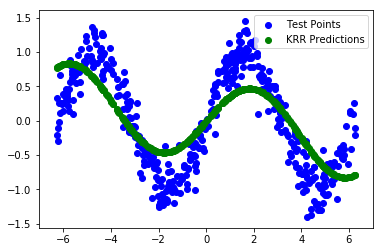

In [19]:
fig, ax = plt.subplots()

ax.scatter(x_test[::20], y_test[::20], color='b', label='Test Points')
ax.scatter(x_test[::20], y_pred[::20], color='g', label='KRR Predictions')


ax.legend()
plt.show()